# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.

### First, download the data from: https://www.kaggle.com/ntnu-testimon/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?
### Note: don't use the entire dataset, use a sample instead, with n=100000 elements, so your computer doesn't freeze.

In [1]:
# Your code here
import pandas as pd
import zipfile

zf = zipfile.ZipFile('archive.zip') 

fraud_detection = pd.read_csv(zf.open('PS_20174392719_1491204439457_log.csv'), header=0, encoding='ISO-8859-1')
fraud_detection.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [2]:
sample_df = fraud_detection.sample(100000)
sample_df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,100000.000000,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,100000.000000,100000.0
mean,243.102820,1.771515e+05,8.306381e+05,8.527292e+05,1.113041e+06,1.233564e+06,0.001180,0.0
std,141.988874,5.487873e+05,2.867986e+06,2.906220e+06,3.462912e+06,3.713160e+06,0.034331,0.0
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,155.000000,1.343541e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,240.000000,7.484095e+04,1.437550e+04,0.000000e+00,1.335897e+05,2.159142e+05,0.000000,0.0
75%,334.000000,2.087613e+05,1.068442e+05,1.433623e+05,9.489457e+05,1.115674e+06,0.000000,0.0
max,738.000000,4.178125e+07,3.440745e+07,3.440795e+07,2.279433e+08,2.281226e+08,1.000000,0.0


In [3]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 2380020 to 5299578
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            100000 non-null  int64  
 1   type            100000 non-null  object 
 2   amount          100000 non-null  float64
 3   nameOrig        100000 non-null  object 
 4   oldbalanceOrg   100000 non-null  float64
 5   newbalanceOrig  100000 non-null  float64
 6   nameDest        100000 non-null  object 
 7   oldbalanceDest  100000 non-null  float64
 8   newbalanceDest  100000 non-null  float64
 9   isFraud         100000 non-null  int64  
 10  isFlaggedFraud  100000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 9.2+ MB


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(sample_df.corr(), dtype=np.bool))
heatmap = sns.heatmap(sample_df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

NameError: name 'np' is not defined

<Figure size 1152x432 with 0 Axes>

### What is the distribution of the outcome? 

<AxesSubplot:>

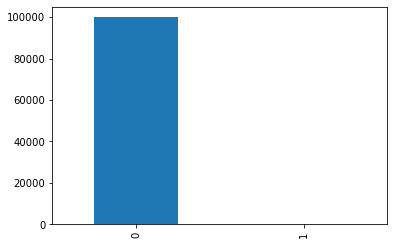

In [5]:
# Your response here
import numpy as np
import matplotlib.pyplot as plt

pd.value_counts(sample_df['isFraud']).plot(kind = 'bar')

### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

<AxesSubplot:>

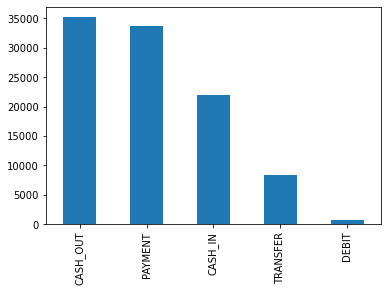

In [6]:
# Your code here
pd.value_counts(sample_df['type']).plot(kind = 'bar')

In [7]:
sample_df = pd.get_dummies(sample_df, columns=['type'])
sample_df.drop(['nameOrig','nameDest'], axis = 1, inplace=True)
sample_df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
2380020,193,7810.36,748.00,0.00,0.00,0.00,0,0,0,0,0,1,0
2262966,187,209182.26,0.00,0.00,4456346.19,4665528.45,0,0,0,1,0,0,0
1852794,164,3551.79,49561.10,46009.31,0.00,0.00,0,0,0,0,0,1,0
679911,36,1503.66,918804.71,917301.06,0.00,0.00,0,0,0,0,0,1,0
2795367,216,8889.48,663.00,0.00,0.00,0.00,0,0,0,0,0,1,0


### Run a logisitc regression classifier and evaluate its accuracy.

In [23]:
# Your code here
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

data = sample_df.drop(labels='isFraud', axis=1)
target = sample_df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size= 0.2)

LR = LogisticRegression()
LR.fit(X_train,y_train)
LR.score(X_test,y_test)
pred = LR.predict(X_test)

LR.score(X_train,y_train)

C:\Users\msart\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.999975

In [24]:
pred = LR.predict(X_test)
confusion_matrix(y_test, pred)

array([[19975,     1],
       [    0,    24]], dtype=int64)

In [25]:
display(accuracy_score(y_train, LR.predict(X_train)))
display(accuracy_score(y_test, LR.predict(X_test)))

0.999975

0.99995

### Now pick a model of your choice and evaluate its accuracy.

In [26]:
# Your code here
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

clf = GradientBoostingClassifier(n_estimators = 1000
                                ,learning_rate = 1
                                ,max_depth = 1
                                ,random_state = 0).fit(X_train, y_train)

display(clf.score(X_train,y_train))

display(accuracy_score(y_train, clf.predict(X_train)))
display(accuracy_score(y_test, clf.predict(X_test)))

display(confusion_matrix(y_test, clf.predict(X_test)))

0.9853125

0.9853125

0.98485

array([[19690,   286],
       [   17,     7]], dtype=int64)

### Which model worked better and how do you know?

Logistic Regression got a better score based on the accuracy score

### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.